In [161]:
num_workers=4
batch_size = 512
batch_sizes = [16, 32, 64, 128, 256, 1024]


In [194]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.patheffects as PathEffects

cmap = cm.prism

def create_graph(stat: Stats):

    rdata = (stat.data - np.min(stat.data))*1000

    batches = min(stat.num_batches, 25)

    norm = Normalize(vmin=0, vmax=batches)


    for e in range(stat.epochs):
        fig, ax = plt.subplots(figsize=(18, 3))

        ax.set_ylim(0, stat.ranks) # 0..ranks 

        ax.set_xlim(np.min(rdata[e, :, 0:batches])*0.99, np.max(rdata[e, :, 0:batches])*1.01)
        print(np.max(rdata[e, :, 0:batches]))

        ax.set_xlabel("relative time ms")

        ax.set_yticks(list(range(stat.ranks)))
        ax.set_ylabel("rank")
        ax.yaxis.grid(True)
#         ax.grid(which='major', axis='y', linestyle='-', linewidth='0.5', color='black')
#         ax.grid(which='minor', axis='y', linestyle=':', linewidth='0.1', color='black')

        path_effects = [PathEffects.withStroke(linewidth=0.1, foreground='black')]

        for r in range(stat.ranks):
            for i in range(batches):
                col = cmap(norm(i))
                ts = rdata[e, r, i]
                ax.broken_barh([(ts[0], ts[3]-ts[0]), (ts[4], ts[7]-ts[4]), (ts[8], ts[9]-ts[8])], (r, 1), facecolors=col)

                annot_y = r + i/batches
                
                ax.text(ts[0], annot_y, f"+{i}", fontsize=1, ha='left', c=col, path_effects=path_effects)
#                 ax.text(ts[1], annot_y, "|", fontsize=1, ha='left', c=col, path_effects=path_effects)
#                 ax.text(ts[2], annot_y, "|", fontsize=1, ha='left', c=col, path_effects=path_effects)

                ax.text(ts[4], annot_y, f"-{i}", fontsize=1, ha='left', c=col, path_effects=path_effects)
#                 ax.text(ts[5], annot_y, "|", fontsize=1, ha='left', c=col, path_effects=path_effects)
#                 ax.text(ts[6], annot_y, "|", fontsize=1, ha='left', c=col, path_effects=path_effects)
                
#                 ax.text(ts[8], annot_y, f"={i}", fontsize=1, ha='left', c=col, path_effects=path_effects)

        # plt.figure(figsize=(20,10))
        plt.savefig(f"{stat.model}_{stat.batch_size}_e{e}.png", dpi=1024) 


In [236]:
import re
import numpy as np 


class Stats:   
    def __init__(self, model, all_ranks_data_loading = False):
        self.model = model
        self.all_ranks_data_loading = all_ranks_data_loading
        self.epoch_times = {
            'rank':[],
            'epoch': [],
            't':[],
        }
        
        self.fwd = {
            'rank':[],
            'epoch':[],
            'batch':[],
            'ts':[],
        }

        self.bwd = {
            'rank':[],
            'epoch':[],
            'batch':[],
            'ts':[],
        }

        self.opt = {
            'rank':[],
            'epoch':[],
            'batch':[],
            'ts':[],
        }
        
        self.data_loading = []
        
        self.batch_size = 0
        self.num_batches = 0
        self.ranks = 0
        self.epochs = 0

        self.data = None
        self.epoch_data = None
        self.data_loading_data = None

    def process(self, by_pass = False):
        self.epochs = max(self.epoch_times['epoch'])+1

        if not by_pass:
            assert len(self.fwd['rank']) == self.num_batches * self.ranks * self.epochs
            assert len(self.bwd['rank']) == self.num_batches * self.ranks * self.epochs
            assert len(self.opt['rank']) == self.num_batches * self.ranks * self.epochs
            assert self.ranks == max(self.fwd['rank']) + 1 
            assert self.epochs == max(self.fwd['epoch']) + 1
            assert self.num_batches == max(self.fwd['batch']) + 1

        self.data = np.zeros((self.epochs, self.ranks, self.num_batches, 10))
        
        def set_ts(d, idx):
            for i in range(len(d['ts'])):
                for j in range(len(d['ts'][i])):
                    self.data[d['epoch'][i], d['rank'][i], d['batch'][i], idx+j] = d['ts'][i][j]

        set_ts(self.fwd, 0)
        set_ts(self.bwd, 4)
        set_ts(self.opt, 8)
        
        self.epoch_data = np.zeros((self.epochs, self.ranks))
        
        for i in range(len(self.epoch_times['t'])):
            self.epoch_data[self.epoch_times['epoch'], self.epoch_times['rank']] = self.epoch_times['t']

        if not self.all_ranks_data_loading:   
            assert len(self.data_loading) == self.num_batches * self.epochs * 3

            self.data_loading_data = np.array(self.data_loading).reshape((self.epochs, 1, self.num_batches, 3))
        else:
            assert len(self.data_loading) == self.num_batches * self.epochs * self.ranks * 3

            self.data_loading_data = np.array(self.data_loading).reshape((self.epochs, self.ranks, self.num_batches, 3))
           
        
    def write_to_file(self):
        fname = f"batch_{self.model}_{self.batch_size}.csv"
        with open(fname, "w") as f:
            f.write("batch_size,epoch,rank,batch,fwd_start, fwd_data_rcvd, fwd_calc_done, fwd_end, bwd_start, bwd_data_rcvd, bwd_calc_done, bwd_end, opt_start, opt_end\n")
            shape = np.shape(self.data)
            for e in range(shape[0]):
                for r in range(shape[1]):
                    for b in range(shape[2]):
                        ts = self.data[e, r, b]
                        f.write(f"{self.batch_size}, {e}, {r}, {b}, {ts[0]}, {ts[1]}, {ts[2]}, {ts[3]}, {ts[4]}, {ts[5]}, {ts[6]}, {ts[7]}, {ts[8]}, {ts[9]}\n")
        print(f"{fname} complete!") 
        
        fname = f"epoch_{self.model}_{self.batch_size}.csv"
        with open(fname, "w") as f:
            f.write("batch_size,epoch,rank, time\n")
            shape = np.shape(self.epoch_data)
            for e in range(shape[0]):
                for r in range(shape[1]):
                    ts = self.epoch_data[e, r]
                    f.write(f"{self.batch_size}, {e}, {r}, {ts}\n")
        print(f"{fname} complete!") 
    
        d = self
        fname = f"data_loading_{d.model}_{d.batch_size}.csv"
        with open(fname, "w") as f:
            f.write("epoch,rank, batch,next,cuda\n")
            shape = np.shape(d.data_loading_data) # (self.epochs, self.num_batches, 3)
            for e in range(shape[0]):
                for r in range(shape[1]):
                    for b in range(shape[2]):                    
                        ts = d.data_loading_data[e, r, b]
                        f.write(f"{e}, {r}, {b}, {ts[1]-ts[0]}, {ts[2]-ts[1]}\n")
            print(f"{fname} complete!")
        
    
    
def process_file(file, rank, stat: Stats):   
    with open(file) as fp: 
        lines = fp.readlines()      
        
        for l in lines:
            splits = re.split(':\W*|/| ',l)
            if l.startswith('### fwd_rcvd'):
                stat.fwd['rank'].append(int(splits[2]))
                stat.fwd['epoch'].append(int(splits[3]))
                stat.fwd['batch'].append(int(splits[4]))
                stat.fwd['ts'].append((float(splits[5]), float(splits[6]), float(splits[7]), float(splits[8])))
            elif l.startswith('### bwd_rcvd'):
                stat.bwd['rank'].append(int(splits[2]))
                stat.bwd['epoch'].append(int(splits[3]))
                stat.bwd['batch'].append(int(splits[4]))
                stat.bwd['ts'].append((float(splits[5]), float(splits[6]), float(splits[7]), float(splits[8])))
            elif l.startswith('### opt_step'):
                stat.opt['rank'].append(int(splits[2]))
                stat.opt['epoch'].append(int(splits[3]))
                stat.opt['batch'].append(int(splits[4]))
                stat.opt['ts'].append((float(splits[5]), float(splits[6])))            
            elif l.startswith('### batch size'):
                stat.batch_size = int(splits[3])
            elif l.startswith('### num iterations:'):
                stat.num_batches = int(splits[3])
            elif l.startswith('Finished initializing process group;'):
                stat.ranks = int(splits[-1])
            elif l.startswith('Epoch') and "start:" in l and "end:" in l:
                stat.epoch_times['rank'].append(int(splits[1]))
                stat.epoch_times['epoch'].append(int(splits[2]))
                stat.epoch_times['t'].append(float(splits[3]))
            elif l.startswith("### rcvt0") or l.startswith("### rcvt1") or l.startswith("### rcv2"):
                stat.data_loading.append(float(splits[2]))
                
        print(f"{file} done!")  

  

/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs/models.alexnet.gpus=4_straight/512_0.log done!
/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs/models.alexnet.gpus=4_straight/512_1.log done!
/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs/models.alexnet.gpus=4_straight/512_2.log done!
/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs/models.alexnet.gpus=4_straight/512_3.log done!
batch_pipe_models.alexnet.gpus=4_straight_512.csv complete!
epoch_pipe_models.alexnet.gpus=4_straight_512.csv complete!
data_loading_pipe_models.alexnet.gpus=4_straight_512.csv complete!
43032.999992370605
127785.99977493286
229747.99990653992


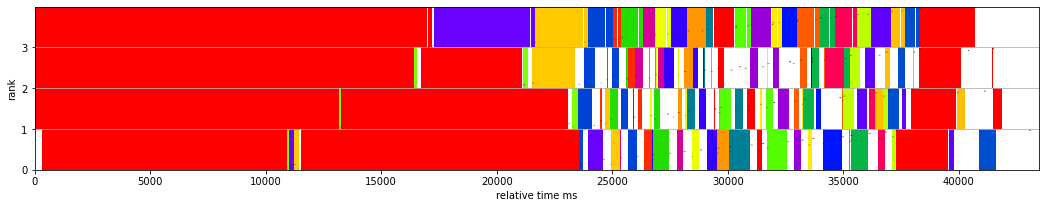

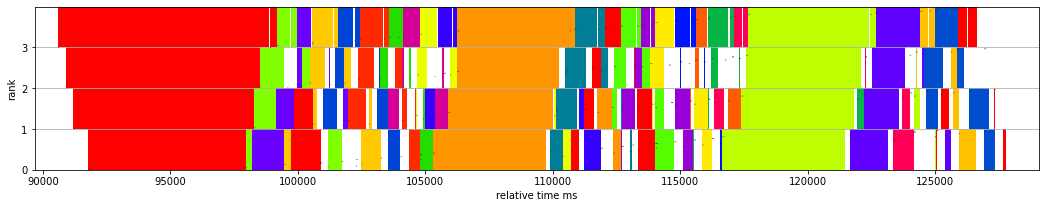

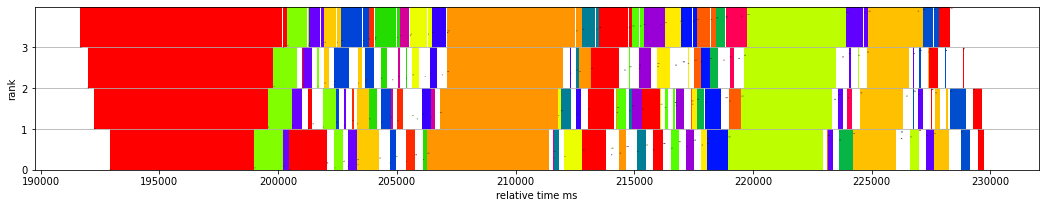

In [231]:
### pipedream 
data_dir='/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs/models.alexnet.gpus=4_straight'
pipe_stats = Stats("pipe_" + data_dir.split('/')[-1])

for w in range(num_workers):
    file = f"{data_dir}/{batch_size}_{w}.log"
    process_file(file, w, pipe_stats)

pipe_stats.process()
pipe_stats.write_to_file()

create_graph(pipe_stats)

/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs/models.alexnet.gpus=4_straight/64_0.log done!
/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs/models.alexnet.gpus=4_straight/64_1.log done!
/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs/models.alexnet.gpus=4_straight/64_2.log done!
/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs/models.alexnet.gpus=4_straight/64_3.log done!
batch_pipe_models.alexnet.gpus=4_straight_64.csv complete!
epoch_pipe_models.alexnet.gpus=4_straight_64.csv complete!
data_loading_pipe_models.alexnet.gpus=4_straight_64.csv complete!
13223.000049591064
171809.0000152588
336617.0001029968


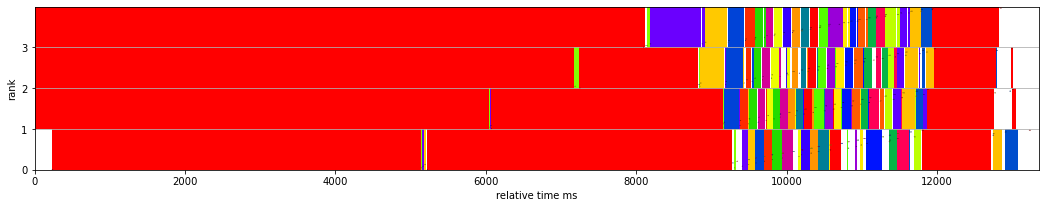

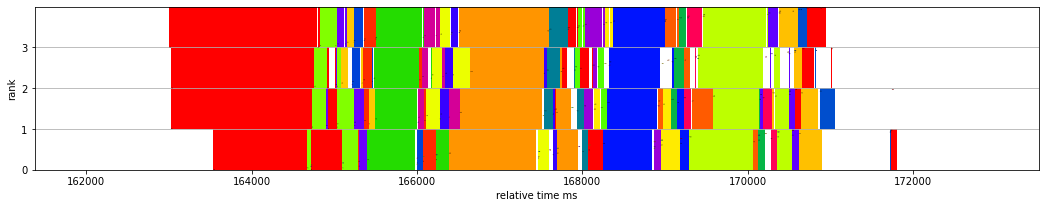

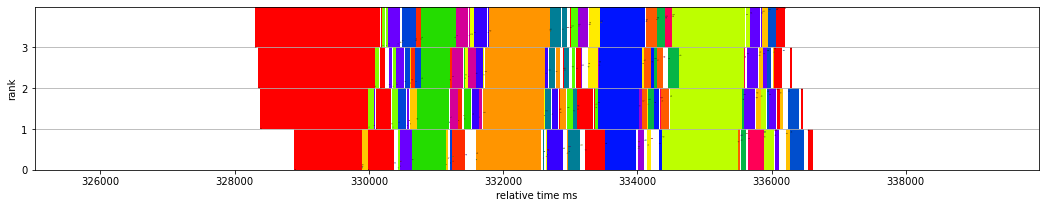

In [229]:
### pipedream  256
data_dir='/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs/models.alexnet.gpus=4_straight'
pipe_stats_64 = Stats("pipe_" + data_dir.split('/')[-1])

for w in range(num_workers):
    file = f"{data_dir}/64_{w}.log"
    process_file(file, w, pipe_stats_64)

pipe_stats_64.process()
pipe_stats_64.write_to_file()

create_graph(pipe_stats_64)

In [217]:
d = pipe_stats

fname = f"data_loading_{d.model}_{d.batch_size}.csv"
with open(fname, "w") as f:
    f.write("epoch,batch,next,cuda\n")
    shape = np.shape(d.data_loading_data) # (self.epochs, self.num_batches, 3)
    for e in range(shape[0]):
        for b in range(shape[1]):
            ts = d.data_loading_data[e, b]
            f.write(f"{e}, {b}, {ts[1]-ts[0]}, {ts[2]-ts[1]}\n")
    print(f"{fname} complete!") 

data_loading_pipe_models.alexnet.gpus=4_straight_512.csv complete!


/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs_dp/models.alexnet.gpus=4_straight/512_0.log done!
/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs_dp/models.alexnet.gpus=4_straight/512_1.log done!
/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs_dp/models.alexnet.gpus=4_straight/512_2.log done!
/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs_dp/models.alexnet.gpus=4_straight/512_3.log done!
batch_data_models.alexnet.gpus=4_straight_512.csv complete!
epoch_data_models.alexnet.gpus=4_straight_512.csv complete!
41786.99994087219
72497.99990653992
104359.99989509583


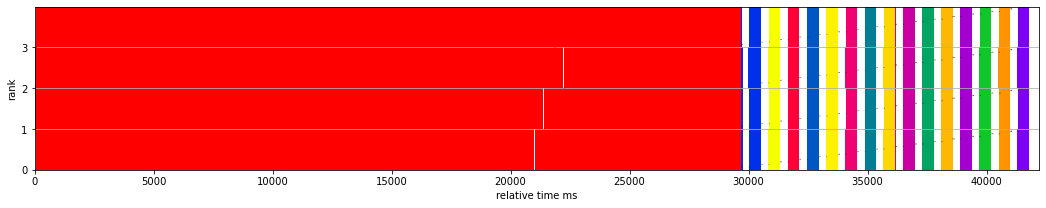

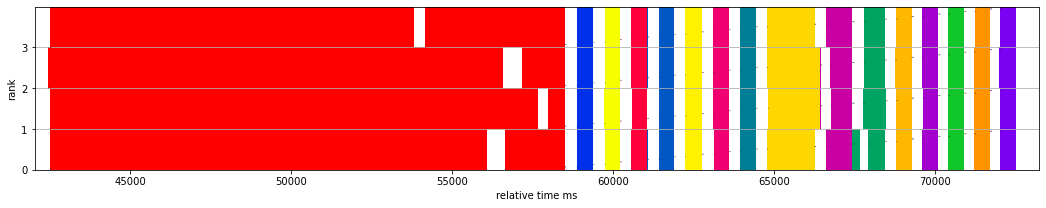

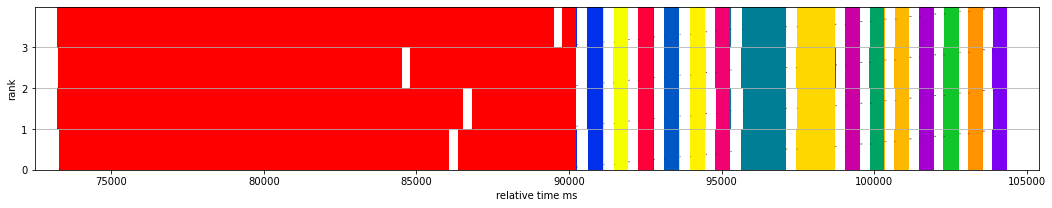

In [195]:
### data parallel 
data_dir='/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs_dp/models.alexnet.gpus=4_straight'
data_stats = Stats("data_" +data_dir.split('/')[-1], True)

for w in range(num_workers):
    file = f"{data_dir}/{batch_size}_{w}.log"
    process_file(file, w, data_stats)

data_stats.process()
data_stats.write_to_file()

create_graph(data_stats)

/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs_1/models.alexnet.gpus=4_straight/512_0.log done!
batch_seq_models.alexnet.gpus=4_straight_512.csv complete!
epoch_seq_models.alexnet.gpus=4_straight_512.csv complete!
data_loading_seq_models.alexnet.gpus=4_straight_512.csv complete!
37977.9999256134
92967.0000076294
147850.00014305115


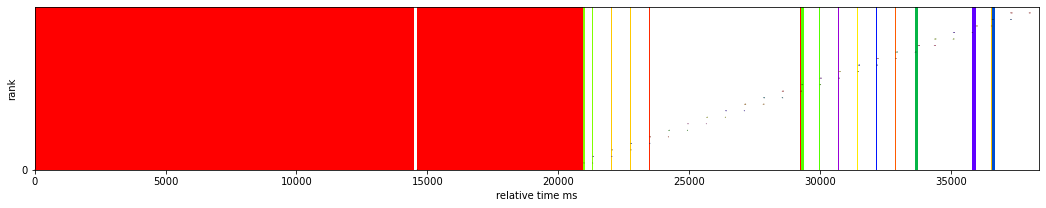

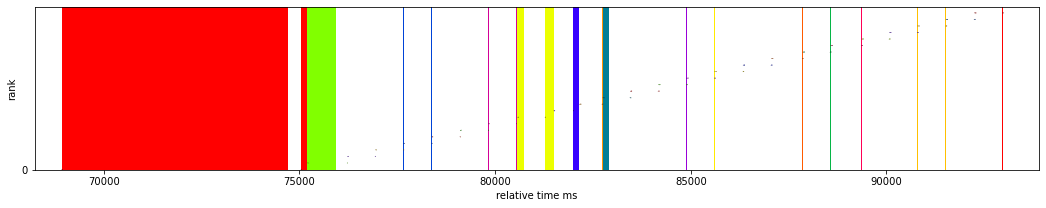

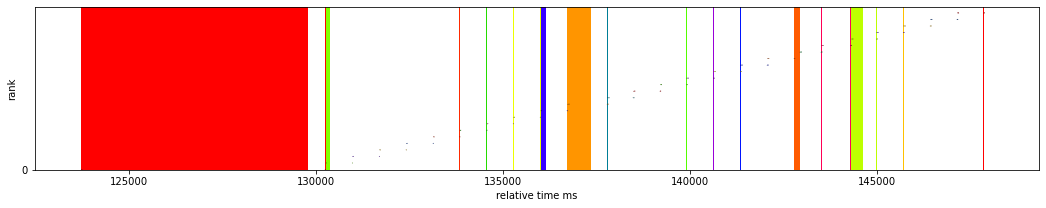

In [226]:
### seq
seq_dir='/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs_1/models.alexnet.gpus=4_straight'
seq_data = Stats("seq_" +seq_dir.split('/')[-1], True)

file = f"{seq_dir}/{batch_size}_0.log"
process_file(file, w, seq_data)

seq_data.process()
seq_data.write_to_file()

create_graph(seq_data)

In [212]:
### temp parallel 
temp_dir='/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs_temp/models.alexnet.gpus=4_straight'
temp_stats = Stats("temp_" +temp_dir.split('/')[-1], False)

for w in range(num_workers):
    file = f"{temp_dir}/{batch_size}_{w}.log"
    process_file(file, w, temp_stats)

temp_stats.process()
temp_stats.write_to_file()

temp_stats.epoch_data

/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs_temp/models.alexnet.gpus=4_straight/512_0.log done!
/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs_temp/models.alexnet.gpus=4_straight/512_1.log done!
/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs_temp/models.alexnet.gpus=4_straight/512_2.log done!
/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs_temp/models.alexnet.gpus=4_straight/512_3.log done!
batch_temp_models.alexnet.gpus=4_straight_512.csv complete!
epoch_temp_models.alexnet.gpus=4_straight_512.csv complete!


array([[89.28 , 89.519, 89.264, 88.955],
       [80.586, 81.095, 81.052, 81.027],
       [80.467, 81.002, 81.052, 81.066],
       [81.126, 81.65 , 81.647, 81.642],
       [78.666, 79.245, 79.228, 79.191],
       [80.422, 80.94 , 80.933, 80.981],
       [83.067, 83.656, 83.661, 83.615],
       [80.726, 81.28 , 81.291, 81.314],
       [81.207, 81.766, 81.772, 81.78 ],
       [79.6  , 80.174, 80.139, 79.938],
       [80.08 , 80.584, 80.619, 80.823],
       [80.589, 81.167, 81.157, 81.126],
       [83.388, 83.984, 83.977, 83.968],
       [80.661, 81.218, 81.233, 81.27 ],
       [81.829, 82.403, 82.389, 82.382],
       [81.705, 82.268, 82.253, 82.259],
       [80.896, 81.452, 81.453, 81.483],
       [79.308, 79.884, 79.885, 79.863],
       [80.075, 80.65 , 80.646, 80.638],
       [80.826, 81.379, 81.431, 81.499]])

In [208]:
d=temp_data
print(d.num_batches)
print(d.ranks)
print(d.epochs)
print(len(d.fwd['rank']))
print(np.min(d.data))

print(len(d.opt['rank']))

print(len(d.fwd['rank']))

print(len(d.data_loading))
print(d.fwd['batch'])

67
4
20
1340
None
1340
1340
4020
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50

In [138]:
print(pipe_stats.num_batches)
print(pipe_stats.ranks)
print(pipe_stats.epochs)
print(len(pipe_stats.fwd['rank']))
print(np.min(pipe_stats.data))

np.argwhere(pipe_stats.data== 0.0)

print(len(pipe_stats.opt['rank']))

print(len(pipe_stats.fwd['rank']))

67
4
3
804
1590852450.996
804
804


In [143]:
print([x for x in pipe_stats.data[-1,-1,-1]])

[1590853067.489, 1590853072.393, 1590853072.395, 1590853072.395, 1590853072.426, 1590853072.426, 1590853072.428, 1590853072.428, 1590853072.428, 1590853072.429]


In [170]:
print([x for x in pipe_stats.data_loading_data[0]])

[1590956108.020156, 1590956114.4231884, 1590956114.4249697]


In [237]:
# save data to csv

fname = f"{data_dir.split('/')[-1]}_{batch_size}.csv"
with open(fname, "w") as f:
    f.write("batch_size,epoch,rank,batch,fwd_start_ts, fwd_end_ts, bwd_start_ts, bwd_end_ts\n")
    shape = np.shape(data)pipe_stats.data_loading_data
    for r in range(shape[0]):
        for e in range(shape[1]):
            for b in range(shape[2]):
                ts = data[r, e, b]
                f.write(f"{batch_size}, {e}, {r}, {b}, {ts[0]}, {ts[1]}, {ts[2]}, {ts[3]}\n")
print(f"{fname} complete!")                
        

models.alexnet.gpus=4_straight_256.csv complete!


/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs/models.alexnet.gpus=4_straight/64_0.log done!
/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs/models.alexnet.gpus=4_straight/64_1.log done!
/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs/models.alexnet.gpus=4_straight/64_2.log done!
/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs/models.alexnet.gpus=4_straight/64_3.log done!
batch_pipe_models.alexnet.gpus=4_straight_64.csv complete!
epoch_pipe_models.alexnet.gpus=4_straight_64.csv complete!
data_loading_pipe_models.alexnet.gpus=4_straight_64.csv complete!
12233.999967575073
171993.00003051758
337486.9999885559
/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs_dp/models.alexnet.gpus=4_straight/64_0.log done!
/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs_dp/models.alexnet.gpus=4_straight/64_1.log done!
/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs_dp/models.alexnet.gpus=

/N/u2/d/dnperera/.conda/envs/pt_new3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


237950.00004768372
/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs_dp/models.alexnet.gpus=4_straight/256_0.log done!
/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs_dp/models.alexnet.gpus=4_straight/256_1.log done!
/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs_dp/models.alexnet.gpus=4_straight/256_2.log done!
/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs_dp/models.alexnet.gpus=4_straight/256_3.log done!
batch_data_models.alexnet.gpus=4_straight_256.csv complete!
epoch_data_models.alexnet.gpus=4_straight_256.csv complete!
data_loading_data_models.alexnet.gpus=4_straight_256.csv complete!
37430.0000667572
72669.0001487732
111111.99998855591
/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs_1/models.alexnet.gpus=4_straight/256_0.log done!
batch_seq_models.alexnet.gpus=4_straight_256.csv complete!
epoch_seq_models.alexnet.gpus=4_straight_256.csv complete!
data_loading_seq_models.alexnet.gpus=4_straight_2

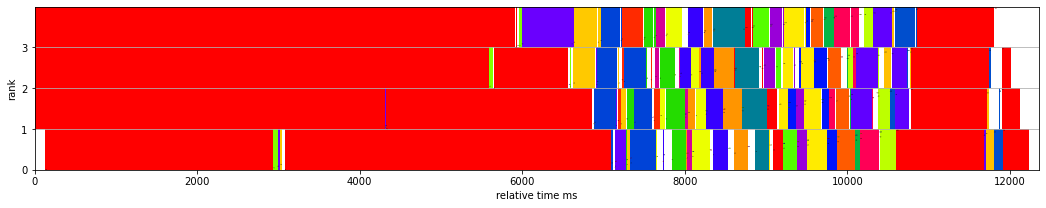

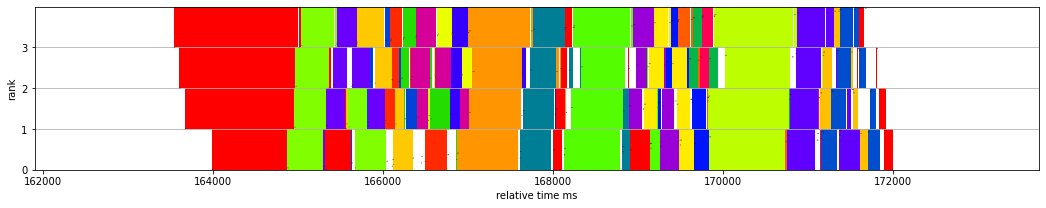

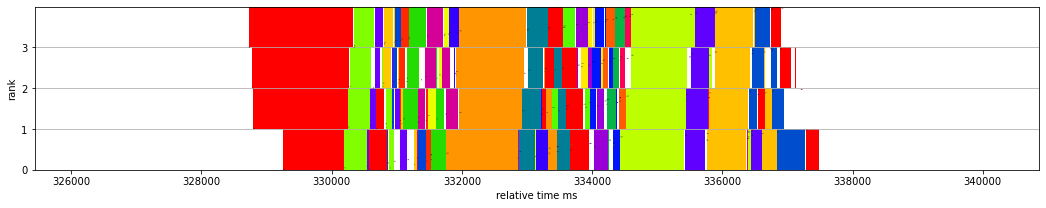

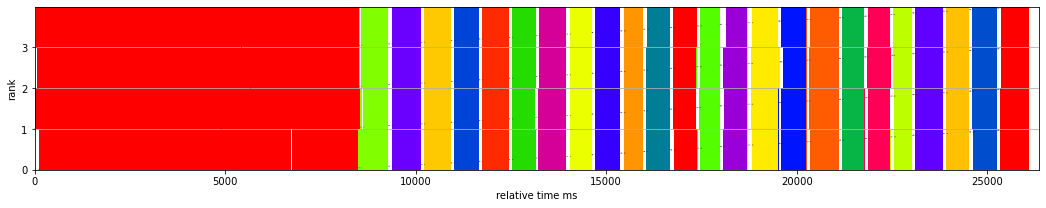

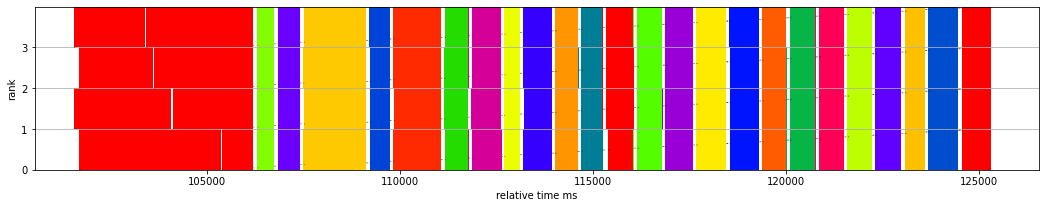

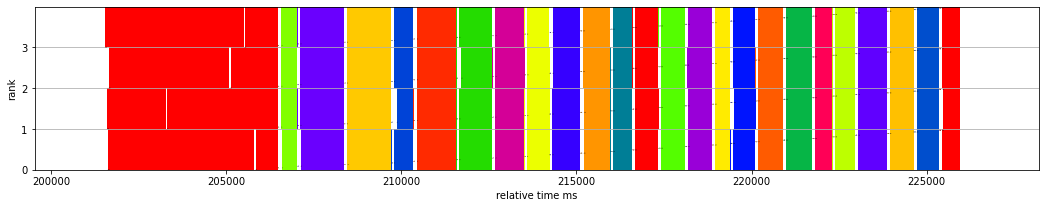

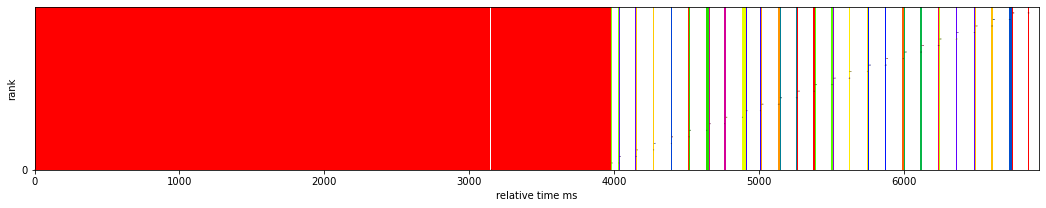

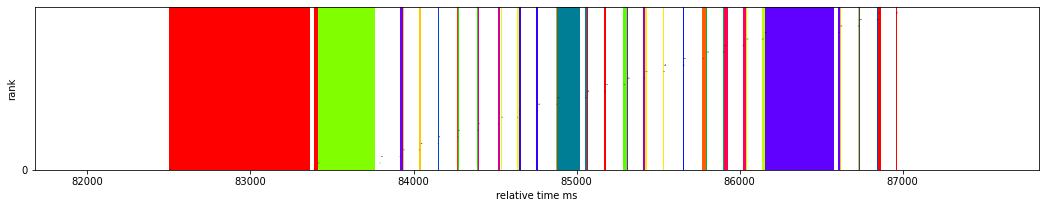

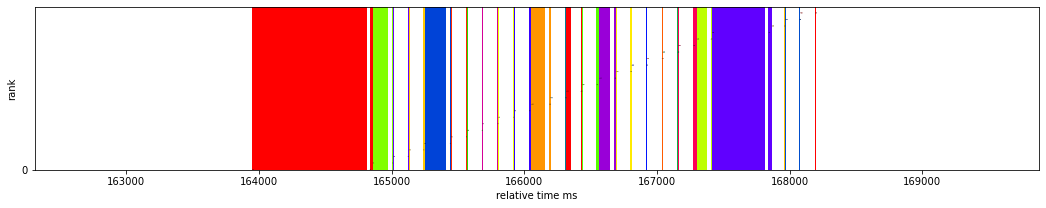

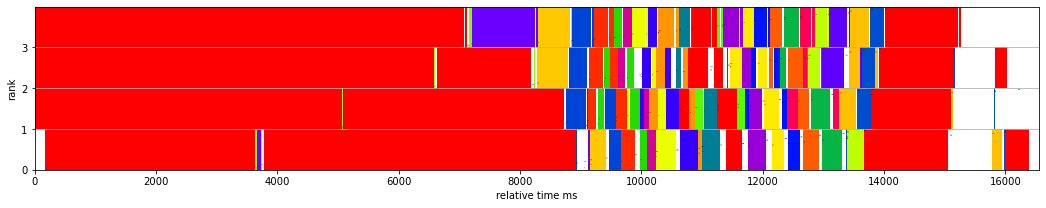

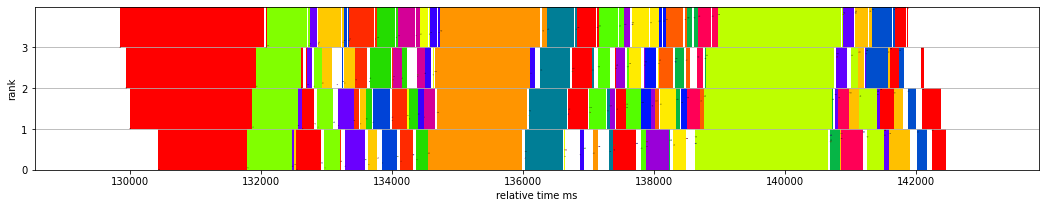

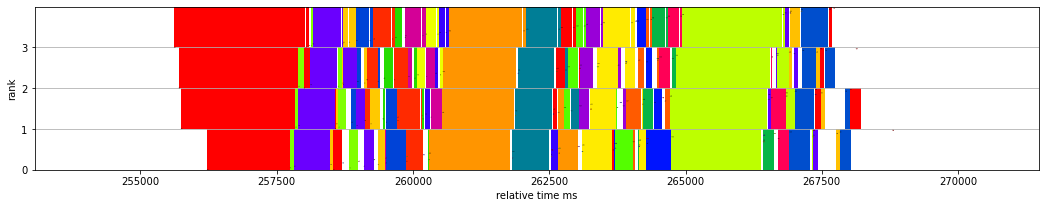

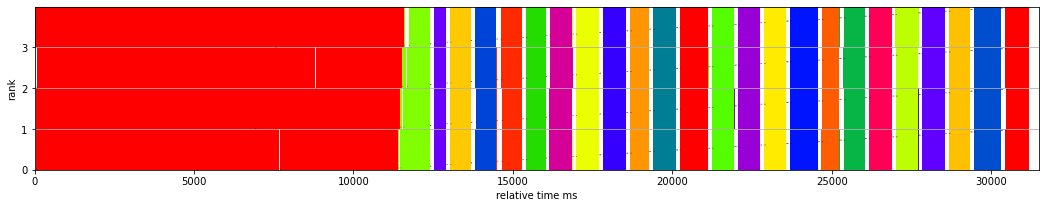

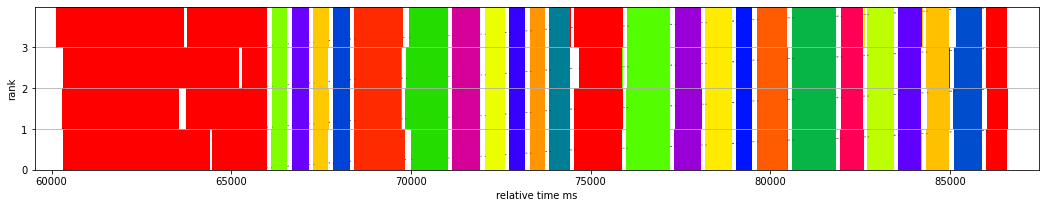

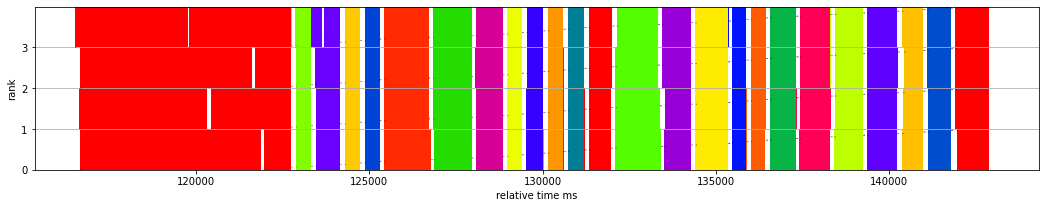

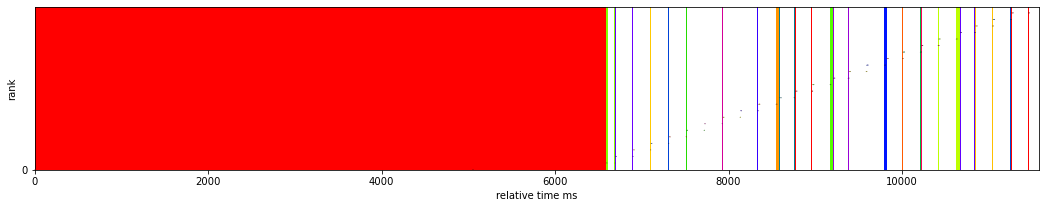

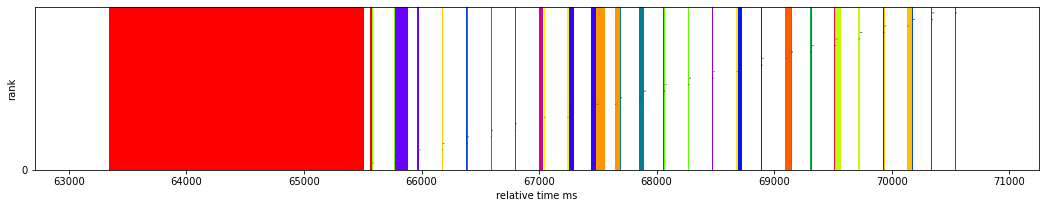

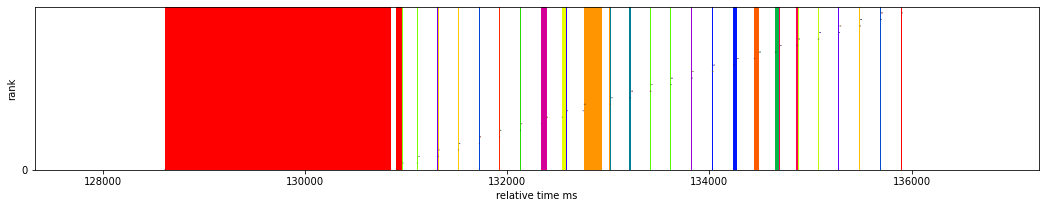

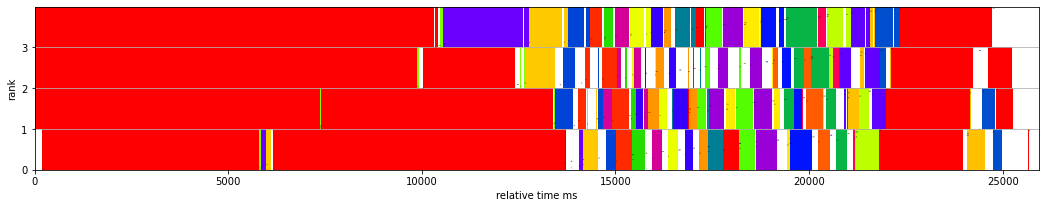

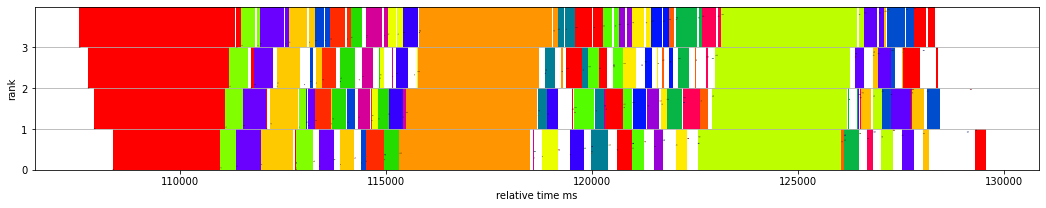

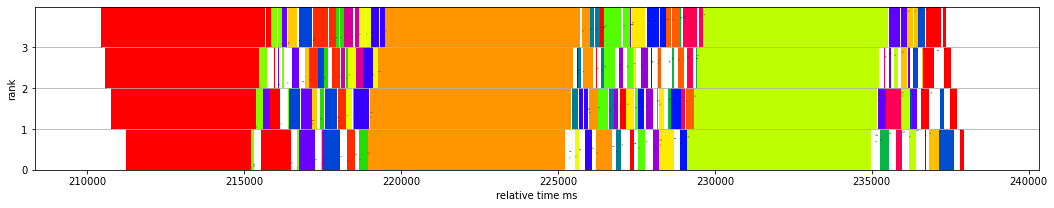

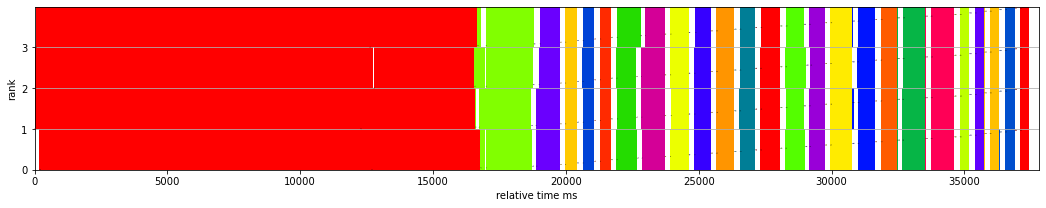

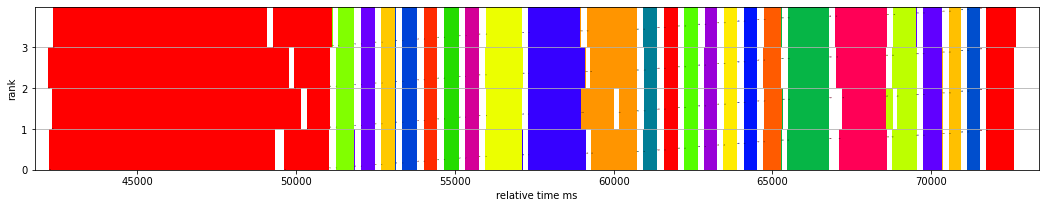

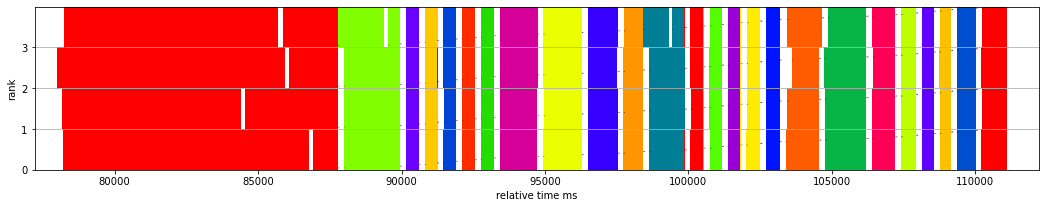

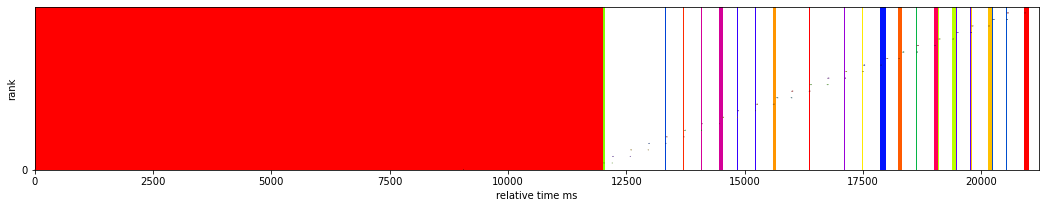

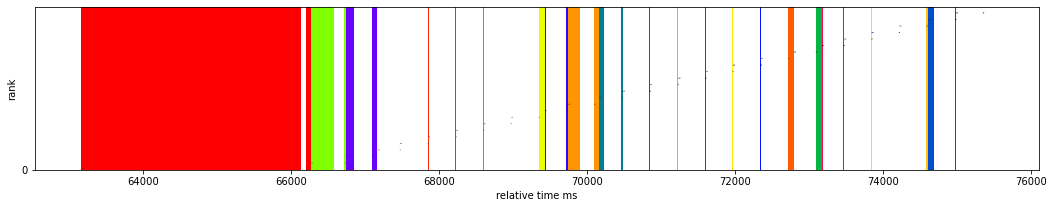

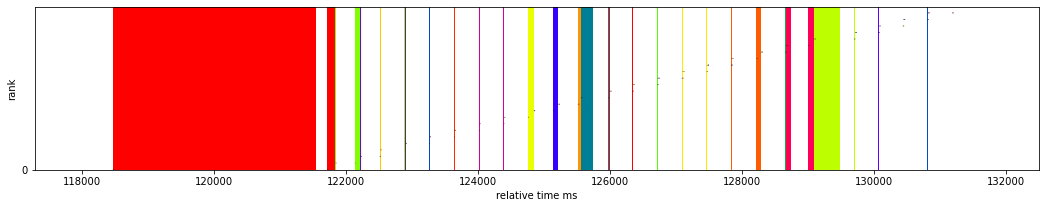

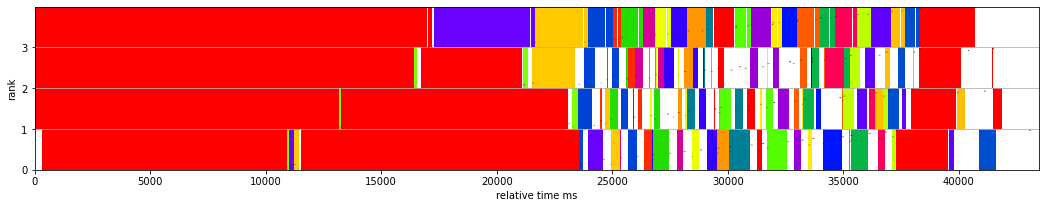

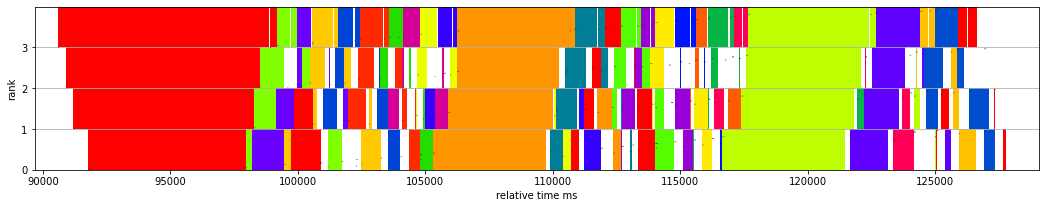

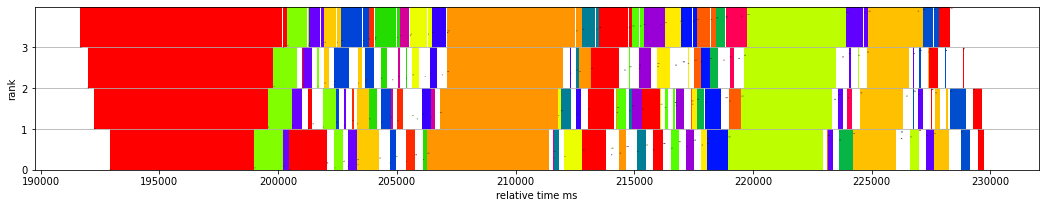

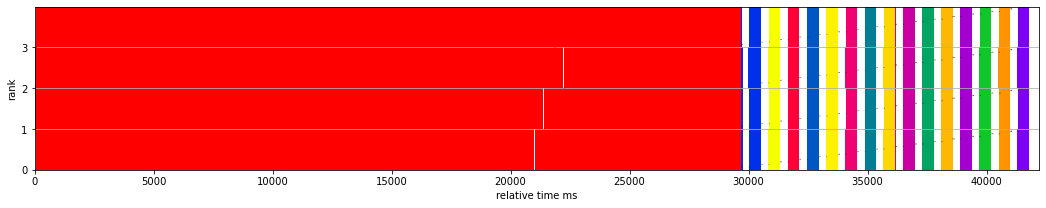

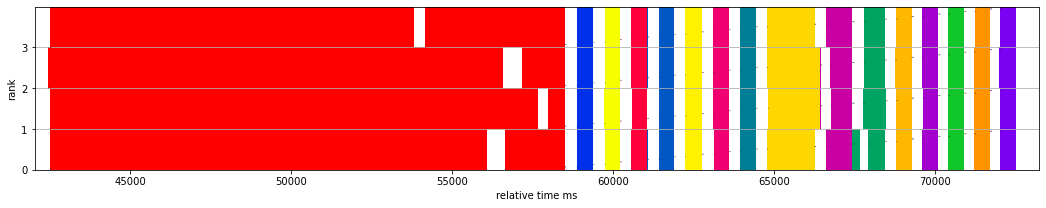

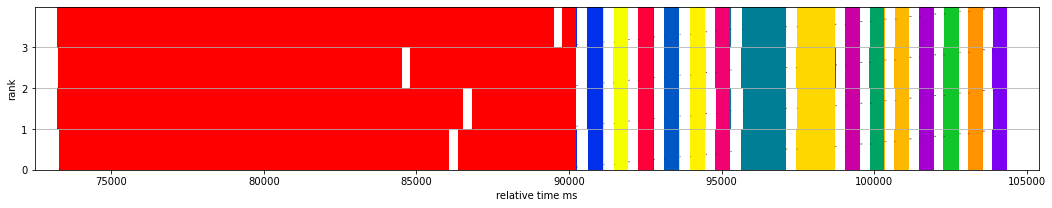

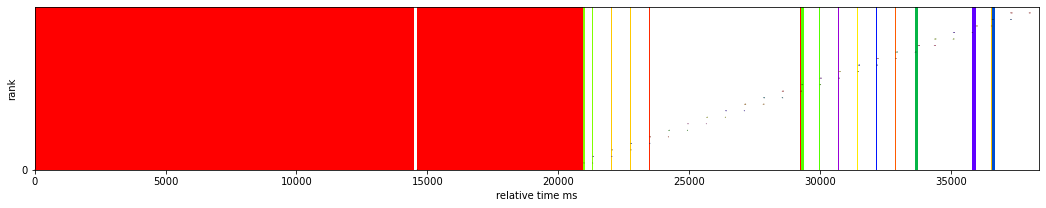

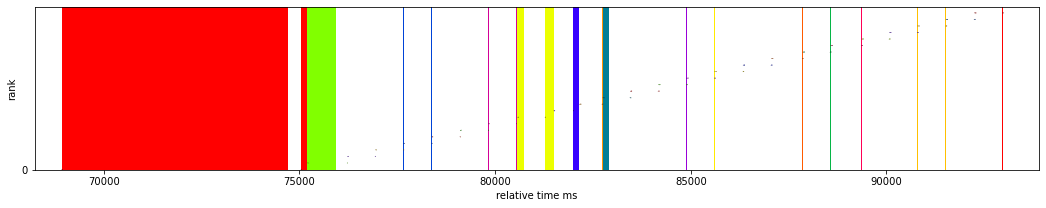

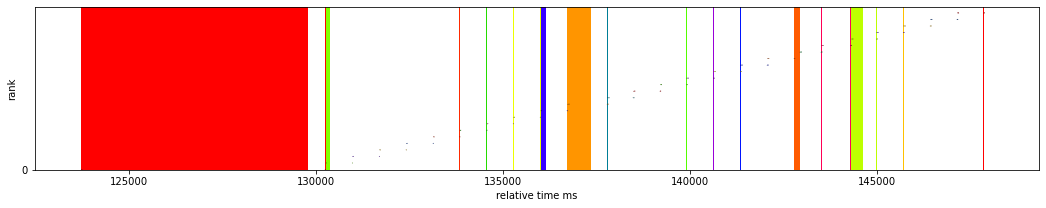

In [232]:
for batch_size in [64, 128, 256, 512]:
    
    ### pipedream 
    data_dir='/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs/models.alexnet.gpus=4_straight'
    pipe_stats = Stats("pipe_" + data_dir.split('/')[-1])

    for w in range(num_workers):
        file = f"{data_dir}/{batch_size}_{w}.log"
        process_file(file, w, pipe_stats)

    pipe_stats.process()
    pipe_stats.write_to_file()

    create_graph(pipe_stats)


    ### data parallel 
    data_dir='/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs_dp/models.alexnet.gpus=4_straight'
    data_stats = Stats("data_" +data_dir.split('/')[-1], True)

    for w in range(num_workers):
        file = f"{data_dir}/{batch_size}_{w}.log"
        process_file(file, w, data_stats)

    data_stats.process()
    data_stats.write_to_file()

    create_graph(data_stats)

    ### seq
    seq_dir='/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs_1/models.alexnet.gpus=4_straight'
    seq_data = Stats("seq_" +seq_dir.split('/')[-1], True)

    file = f"{seq_dir}/{batch_size}_0.log"
    process_file(file, w, seq_data)

    seq_data.process()
    seq_data.write_to_file()

    create_graph(seq_data)


/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs/alexnet_4_hybrid_conf/64_0.log done!
/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs/alexnet_4_hybrid_conf/64_1.log done!
/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs/alexnet_4_hybrid_conf/64_2.log done!
/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs/alexnet_4_hybrid_conf/64_3.log done!
batch_pipe_hybrid_alexnet_4_hybrid_conf_64.csv complete!
epoch_pipe_hybrid_alexnet_4_hybrid_conf_64.csv complete!
data_loading_pipe_hybrid_alexnet_4_hybrid_conf_64.csv complete!
1591152915129.0
1591153020543.0
1591153129327.0
/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs/alexnet_4_hybrid_conf/128_0.log done!
/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs/alexnet_4_hybrid_conf/128_1.log done!
/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs/alexnet_4_hybrid_conf/128_2.log done!
/N/u2/d/dnperera/git/pipedream/runtime/image_classificati

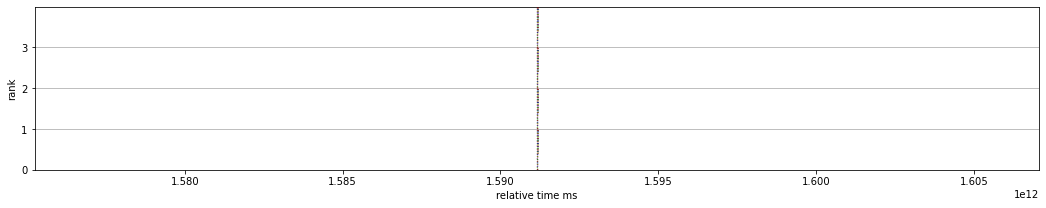

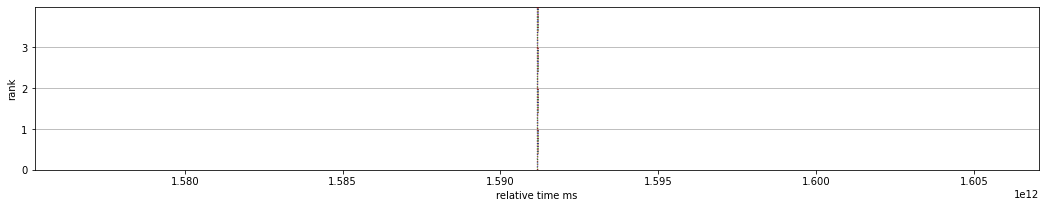

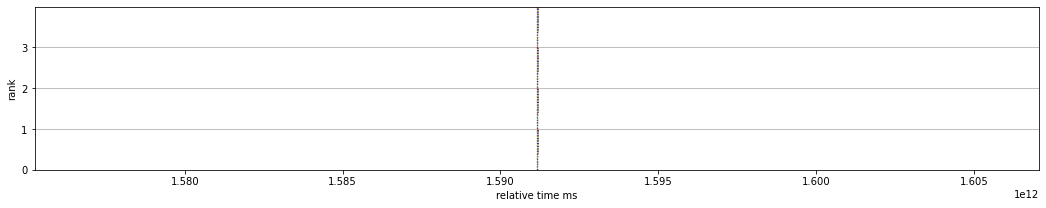

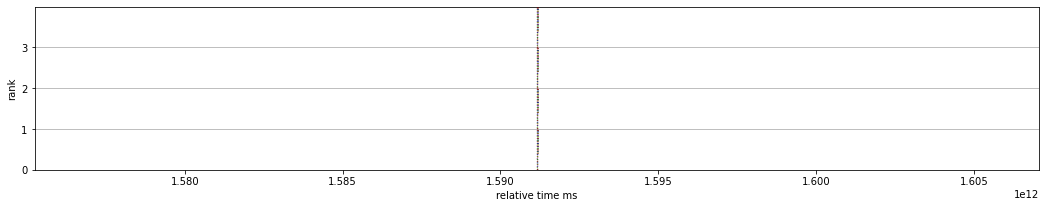

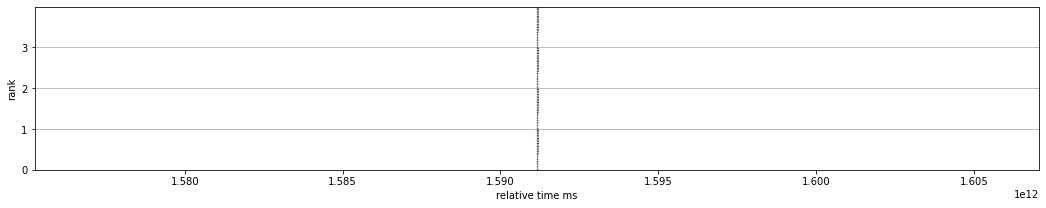

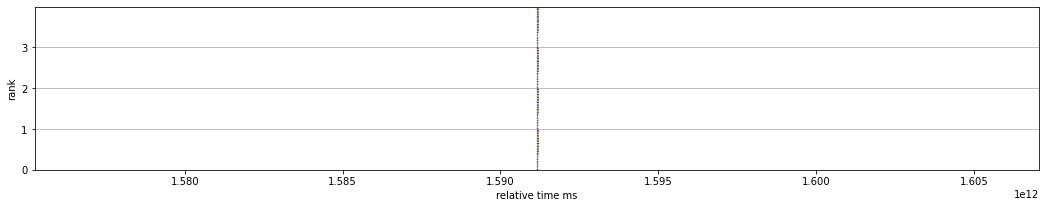

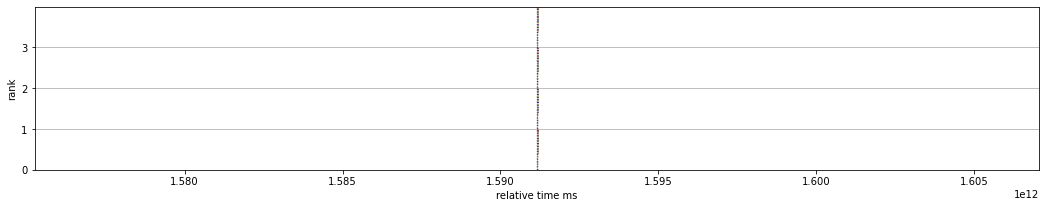

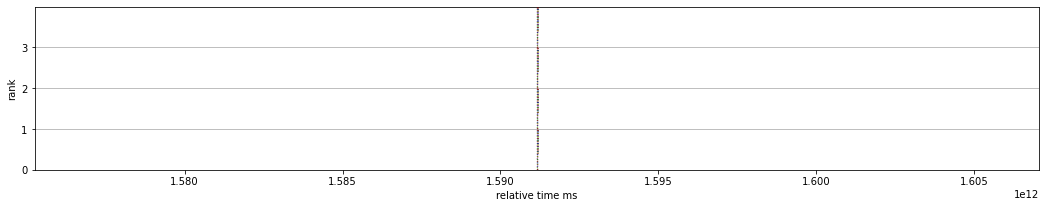

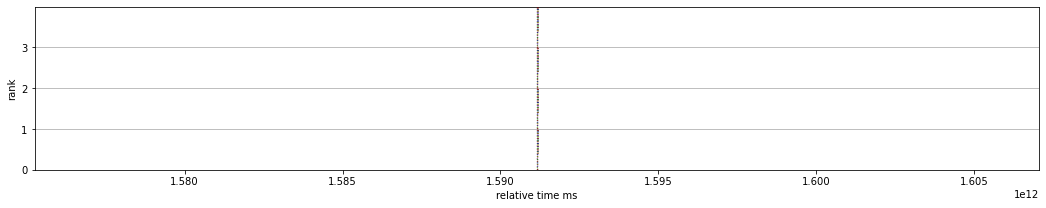

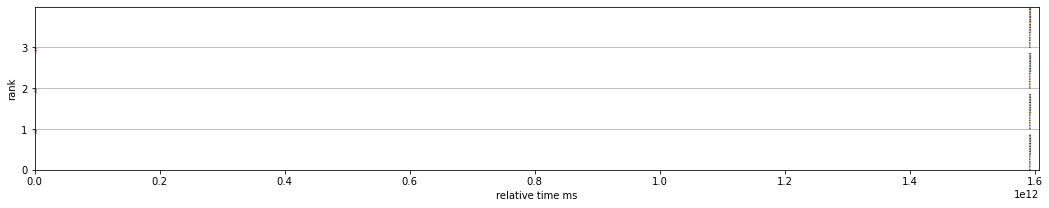

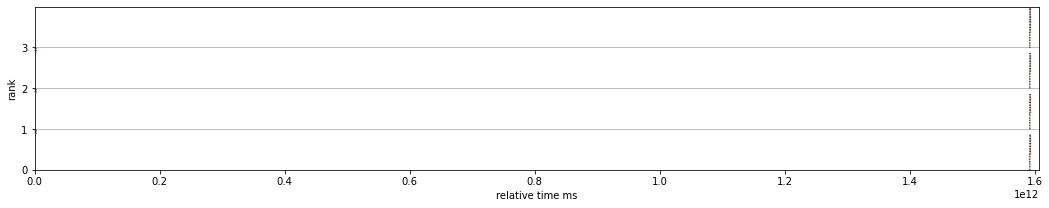

In [ ]:
for batch_size in [64, 128, 256, 512]:
    
    ### pipedream 
    data_dir='/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs/alexnet_4_hybrid_conf'
    pipe_stats = Stats("pipe_hybrid_" + data_dir.split('/')[-1])

    for w in range(num_workers):
        file = f"{data_dir}/{batch_size}_{w}.log"
        process_file(file, w, pipe_stats)

    pipe_stats.process(True)
    pipe_stats.write_to_file()

    create_graph(pipe_stats)